<b>U-Net</b>

In [1]:
import numpy as np
import torch

seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
# Dataset

from torchvision import datasets, transforms
import torch.utils as utils

transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor()])

dataset_train = datasets.MNIST(
    '~/mnist', 
    train=True, 
    download=True, 
    transform=transform)
dataset_test  = datasets.MNIST(
    '~/mnist', 
    train=False, 
    download=True, 
    transform=transform)

batch_size = 1000

dataloader_train = utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)
dataloader_test  = utils.data.DataLoader(dataset_test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

Extracting /root/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/mnist/MNIST/raw


Extracting /root/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/mnist/MNIST/raw


Extracting /root/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/mnist/MNIST/raw


Extracting /root/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Network

import torch.nn as nn

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
    )
    self.deconv1 = nn.Sequential(
        nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2),
        nn.ReLU(),
    )
    self.deconv2 =nn.Sequential(
        nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2),
    )

  def forward(self, x1):
    x2 = self.conv1(x1)
    x3 = self.conv2(x2)
    x4 = self.deconv1(x3)
    x5 = torch.cat((x4, x2), dim=1)
    y  = self.deconv2(x5)
    return y

In [4]:
# Training

from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for i in range(30):
  print(f"EPOCH: {i+1}")

  ### Train ###
  model.train()
  for x, _ in dataloader_train:
    x = x.to(device)
    model.zero_grad()
    y = model(x)
    loss = criterion(y, x)
    loss.backward()
    optimizer.step()

  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for x, _ in dataloader_train:
    x = x.to(device)
    y = model(x)
    loss = criterion(y, x)
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  train loss: {sum_loss/sum_iter}")

  ### Test ###
  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for x, _ in dataloader_test:
    x = x.to(device)
    y = model(x)
    loss = criterion(y, x)
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  test  loss: {sum_loss/sum_iter}")


EPOCH: 1
  train loss: 0.11071349941194057
  test  loss: 0.1113450862467289
EPOCH: 2
  train loss: 0.05377895353982846
  test  loss: 0.0542869109660387
EPOCH: 3
  train loss: 0.023352698205659786
  test  loss: 0.023470593430101872
EPOCH: 4
  train loss: 0.016302201493332783
  test  loss: 0.016330468840897082
EPOCH: 5
  train loss: 0.012614875690390666
  test  loss: 0.012605729792267085
EPOCH: 6
  train loss: 0.01005074349232018
  test  loss: 0.010014367941766977
EPOCH: 7
  train loss: 0.008468443450207511
  test  loss: 0.008427028637379408
EPOCH: 8
  train loss: 0.0072383657330647114
  test  loss: 0.007191372523084283
EPOCH: 9
  train loss: 0.006183295572797457
  test  loss: 0.006136664049699902
EPOCH: 10
  train loss: 0.005261137592606246
  test  loss: 0.005212745955213904
EPOCH: 11
  train loss: 0.004307232579837243
  test  loss: 0.0042567724827677015
EPOCH: 12
  train loss: 0.0036161444382742046
  test  loss: 0.0035698162857443093
EPOCH: 13
  train loss: 0.0031537280262758332
  test

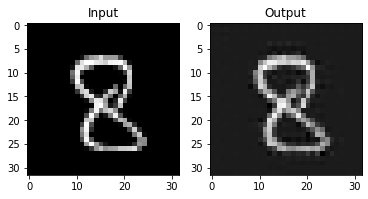

In [5]:
# Visualization

import matplotlib.pyplot as plt
%matplotlib inline

x, t = iter(dataloader_test).next()
x = x.to(device)
y = model(x)
x = np.reshape(x[0].cpu().detach().numpy(), [32, 32])
y = np.reshape(y[0].cpu().detach().numpy(), [32, 32])

plt.gray()
plt.subplot(121)
plt.imshow(x)
plt.title("Input")
plt.subplot(122)
plt.imshow(y)
plt.title("Output")
plt.show()

参考<br>
https://leck-tech.com/machine-learning/u-net